In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mediapipe as mp
import sklearn
import tensorflow

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM ,Dense
from tensorflow.keras.callbacks import TensorBoard

In [3]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [4]:
mp_holistic = mp.solutions.holistic #makes detections
mp_drawing = mp.solutions.drawing_utils #draws detections

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False   #image not writeable
    results = model.process(image)  #make prediction
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [6]:
Data_Path = os.path.join("C:/Users/HOME/Desktop/stuff/Sign-o-Voice/scratch/ISL_Data_Shubham")


In [7]:
actions = np.array(["Book","Do","Eat","Go","Good","Hello","Home","Hungry","I","Morning","No","Not","Pizza" , "Place" ,"Read","School","Student","Teacher","Thank You", "This" , "Tomorrow" ,"Want", "What", "Yes", "Yesterday","You"])
no_sequences = 100   #60 videos
sequence_length =30 #30 frames each 

In [8]:
label_map = {label:num for num , label in enumerate(actions)}

In [9]:
label_map

{'Book': 0,
 'Do': 1,
 'Eat': 2,
 'Go': 3,
 'Good': 4,
 'Hello': 5,
 'Home': 6,
 'Hungry': 7,
 'I': 8,
 'Morning': 9,
 'No': 10,
 'Not': 11,
 'Pizza': 12,
 'Place': 13,
 'Read': 14,
 'School': 15,
 'Student': 16,
 'Teacher': 17,
 'Thank You': 18,
 'This': 19,
 'Tomorrow': 20,
 'Want': 21,
 'What': 22,
 'Yes': 23,
 'Yesterday': 24,
 'You': 25}

In [10]:
def normalize_keypoints(keypoints, center_keypoint, reference_distance):
    # Reshape the keypoints into (x, y, z) coordinates
    keypoints = keypoints.reshape(-1, 3)
    
    # Subtract center keypoint to get relative coordinates
    relative_keypoints = keypoints - center_keypoint
    
    # If reference distance is provided, scale the keypoints
    relative_keypoints = relative_keypoints / reference_distance
    #relative_keypoints = keypoints / reference_distance
    

    return relative_keypoints.flatten()

In [11]:
""" import numpy as np
from scipy.ndimage import uniform_filter1d  # For temporal smoothing

# Function to calculate relative hand keypoints
def preprocess_hand_keypoints(hand_keypoints):
    # If there are hand keypoints, calculate relative positions with respect to the wrist (0th keypoint)
    if np.any(hand_keypoints):
        wrist_keypoint = hand_keypoints[0:3]  # Wrist is the first keypoint in MediaPipe
        relative_hand_keypoints = (hand_keypoints.reshape(-1, 3) - wrist_keypoint)  # Relative to wrist
    else:
        relative_hand_keypoints = np.zeros(21 * 3)  # If no hand keypoints, return zeros
    return relative_hand_keypoints.flatten()

# Normalize keypoints function (includes the pose and hand keypoints)
def normalize_keypoints(keypoints, center_keypoint, reference_distance):
    keypoints = keypoints.reshape(-1, 3)
    
    # Subtract the center keypoint to get relative coordinates
    relative_keypoints = keypoints - center_keypoint
    
    # Scale the keypoints by reference distance (shoulder width)
    relative_keypoints = relative_keypoints / reference_distance

    return relative_keypoints.flatten()

# Preprocessing: Including relative hand keypoints and temporal smoothing
sequences, labels = [], []

for action in actions:
    print(action,"started")
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            frame = np.load(os.path.join(Data_Path, action, str(sequence), f"{frame_num}.npy"))
            
            # Center keypoint (nose) and shoulder distance (for normalization)
            center_keypoint = frame[0:3]  # Nose keypoint (x, y, z)
            left_shoulder = frame[11*3:11*3+3]
            right_shoulder = frame[12*3:12*3+3]
            reference_distance = np.linalg.norm(left_shoulder - right_shoulder)
            if not reference_distance:
                reference_distance = 1
            
            # Normalize the pose keypoints relative to the nose
            normalized_pose = normalize_keypoints(frame[:69], center_keypoint, reference_distance)
            
            # Preprocess left hand keypoints (relative to wrist)
            left_hand = frame[69:69 + 21*3]
            relative_left_hand = preprocess_hand_keypoints(left_hand)
            
            # Preprocess right hand keypoints (relative to wrist)
            right_hand = frame[69 + 21*3:]
            relative_right_hand = preprocess_hand_keypoints(right_hand)
            
            # Concatenate normalized pose, relative left hand, and relative right hand keypoints
            full_frame = np.concatenate([normalized_pose, relative_left_hand, relative_right_hand])
            
            window.append(full_frame)
        
        # Convert the window into a numpy array for smoothing
        window = np.array(window)
        
        # Apply temporal smoothing using a moving average filter
        smoothed_window = uniform_filter1d(window, size=3, axis=0)
        
        sequences.append(smoothed_window)
        labels.append(label_map[action])
    
    print(action, "completed")

# Final shape of sequences (length, 30 frames, keypoints)
print(np.array(sequences).shape)
 """

' import numpy as np\nfrom scipy.ndimage import uniform_filter1d  # For temporal smoothing\n\n# Function to calculate relative hand keypoints\ndef preprocess_hand_keypoints(hand_keypoints):\n    # If there are hand keypoints, calculate relative positions with respect to the wrist (0th keypoint)\n    if np.any(hand_keypoints):\n        wrist_keypoint = hand_keypoints[0:3]  # Wrist is the first keypoint in MediaPipe\n        relative_hand_keypoints = (hand_keypoints.reshape(-1, 3) - wrist_keypoint)  # Relative to wrist\n    else:\n        relative_hand_keypoints = np.zeros(21 * 3)  # If no hand keypoints, return zeros\n    return relative_hand_keypoints.flatten()\n\n# Normalize keypoints function (includes the pose and hand keypoints)\ndef normalize_keypoints(keypoints, center_keypoint, reference_distance):\n    keypoints = keypoints.reshape(-1, 3)\n    \n    # Subtract the center keypoint to get relative coordinates\n    relative_keypoints = keypoints - center_keypoint\n    \n    # Scal

In [42]:
""" np.save("normalized_data_NEW",sequences)
np.save("labels_data_NEW", labels) """

' np.save("normalized_data_NEW",sequences)\nnp.save("labels_data_NEW", labels) '

In [12]:
sequences = np.load("normalized_data_NEW.npy")
labels = np.load("labels_data_NEW.npy")

In [13]:
""" sequences = np.load("normalized_data.npy")
labels = np.load("labels_data.npy") """

' sequences = np.load("normalized_data.npy")\nlabels = np.load("labels_data.npy") '

In [14]:
np.array(sequences).shape  

(2600, 30, 195)

In [15]:
np.array(labels).shape

(2600,)

In [16]:
X = np.array(sequences)

In [17]:
Y = to_categorical(labels).astype(int)  #one hot encoding

In [79]:
""" from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, BatchNormalization, Conv1D
from tensorflow.keras import regularizers
model = Sequential()

# Optional CNN layer for feature extraction
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(30, 195)))

# LSTM Layers with Batch Normalization
model.add(Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.001))))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.001))))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(128, return_sequences=False, kernel_regularizer=regularizers.l2(0.001))))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dense layers
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(actions.shape[0], activation="softmax")) """

In [25]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)  # 5-fold cross-validation
for train_index, val_index in kf.split(X):  
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, BatchNormalization, Conv1D, SpatialDropout1D
from tensorflow.keras import Sequential, regularizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, BatchNormalization, Conv1D
from tensorflow.keras import regularizers


model2 = Sequential()

model2.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(30, 195)))
model2.add(SpatialDropout1D(0.2))

model2.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.001))))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

model2.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.001))))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))

model2.add(Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(0.001))))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))

# Dense layers
model2.add(Dense(64, activation="relu"))
model2.add(Dropout(0.3))

model2.add(Dense(actions.shape[0], activation="softmax"))

In [9]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 64)            37504     
                                                                 
 spatial_dropout1d (SpatialD  (None, 28, 64)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 28, 256)          197632    
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 28, 256)          1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 28, 256)           0         
                                                        

In [26]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopper = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [27]:
history = model2.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        batch_size=64,
        epochs=100,
        callbacks=[early_stopper, lr_scheduler],
        verbose=1
    )

Epoch 1/100
33/33 [==============================] - 11s 154ms/step - loss: 4.6225 - categorical_accuracy: 0.0760 - val_loss: 4.1298 - val_categorical_accuracy: 0.0788 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 4s 121ms/step - loss: 3.9491 - categorical_accuracy: 0.1418 - val_loss: 3.8258 - val_categorical_accuracy: 0.2058 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 5s 142ms/step - loss: 3.4900 - categorical_accuracy: 0.2255 - val_loss: 3.5241 - val_categorical_accuracy: 0.3442 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 4s 124ms/step - loss: 3.0559 - categorical_accuracy: 0.3159 - val_loss: 3.1008 - val_categorical_accuracy: 0.4865 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 4s 129ms/step - loss: 2.7068 - categorical_accuracy: 0.4043 - val_loss: 2.5975 - val_categorical_accuracy: 0.5846 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 4s 135ms/step - loss: 2.3977 - categorical_acc

In [82]:
""" #model1.fit(X_train, Y_train, epochs=150)
history = model.fit(X_train, Y_train, validation_split=0.2, epochs=65, batch_size=64,callbacks=[lr_scheduler, early_stopper]) """

Epoch 1/65
26/26 [==============================] - 22s 648ms/step - loss: 4.8898 - categorical_accuracy: 0.1833 - val_loss: 5.0522 - val_categorical_accuracy: 0.1058 - lr: 0.0010
Epoch 2/65
26/26 [==============================] - 16s 625ms/step - loss: 3.6447 - categorical_accuracy: 0.4447 - val_loss: 4.7640 - val_categorical_accuracy: 0.1851 - lr: 0.0010
Epoch 3/65
26/26 [==============================] - 16s 604ms/step - loss: 2.8587 - categorical_accuracy: 0.6695 - val_loss: 4.3366 - val_categorical_accuracy: 0.1947 - lr: 0.0010
Epoch 4/65
26/26 [==============================] - 16s 599ms/step - loss: 2.4007 - categorical_accuracy: 0.8119 - val_loss: 3.7649 - val_categorical_accuracy: 0.4712 - lr: 0.0010
Epoch 5/65
26/26 [==============================] - 15s 598ms/step - loss: 2.1282 - categorical_accuracy: 0.8732 - val_loss: 3.1495 - val_categorical_accuracy: 0.6250 - lr: 0.0010
Epoch 6/65
26/26 [==============================] - 15s 587ms/step - loss: 1.9738 - categorical_accu

In [85]:
""" model.evaluate(X_test, Y_test, verbose=1) """

17/17 [==============================] - 2s 124ms/step - loss: 0.3045 - categorical_accuracy: 0.9942


[0.3045399785041809, 0.9942307472229004]

In [28]:
model2.evaluate(X_test, Y_test, verbose=1)

21/21 [==============================] - 1s 29ms/step - loss: 0.1659 - categorical_accuracy: 0.9969


[0.16593891382217407, 0.9969230890274048]

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
result = model2.predict(X_test)
Y_pred = np.argmax(result, axis=1)
Y_true = np.argmax(Y_test, axis=1)
print("Classification Report:")
print(classification_report(Y_true, Y_pred, target_names=actions))  # Assuming `class_names` is a list of your class labels

# Optional: Generate a confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(Y_true, Y_pred))

Classification Report:
              precision    recall  f1-score   support

        Book       1.00      1.00      1.00        19
          Do       1.00      1.00      1.00        29
         Eat       1.00      1.00      1.00        17
          Go       1.00      1.00      1.00        28
        Good       1.00      1.00      1.00        37
       Hello       1.00      0.96      0.98        25
        Home       1.00      1.00      1.00        25
      Hungry       0.96      1.00      0.98        24
           I       1.00      1.00      1.00        32
     Morning       1.00      1.00      1.00        18
          No       1.00      1.00      1.00        28
         Not       1.00      1.00      1.00        24
       Pizza       1.00      1.00      1.00        25
       Place       1.00      1.00      1.00        24
        Read       1.00      1.00      1.00        24
      School       1.00      1.00      1.00        27
     Student       1.00      0.96      0.98        23
    

In [30]:
result=list(result)
Y_test=list(Y_test)
actual=[]
predicted=[]
for i in range (0, len(Y_test)):
    actual.append(actions[list(Y_test[i]).index(max(Y_test[i]))])
    predicted.append(actions[list(result[i]).index(max(result[i]))])

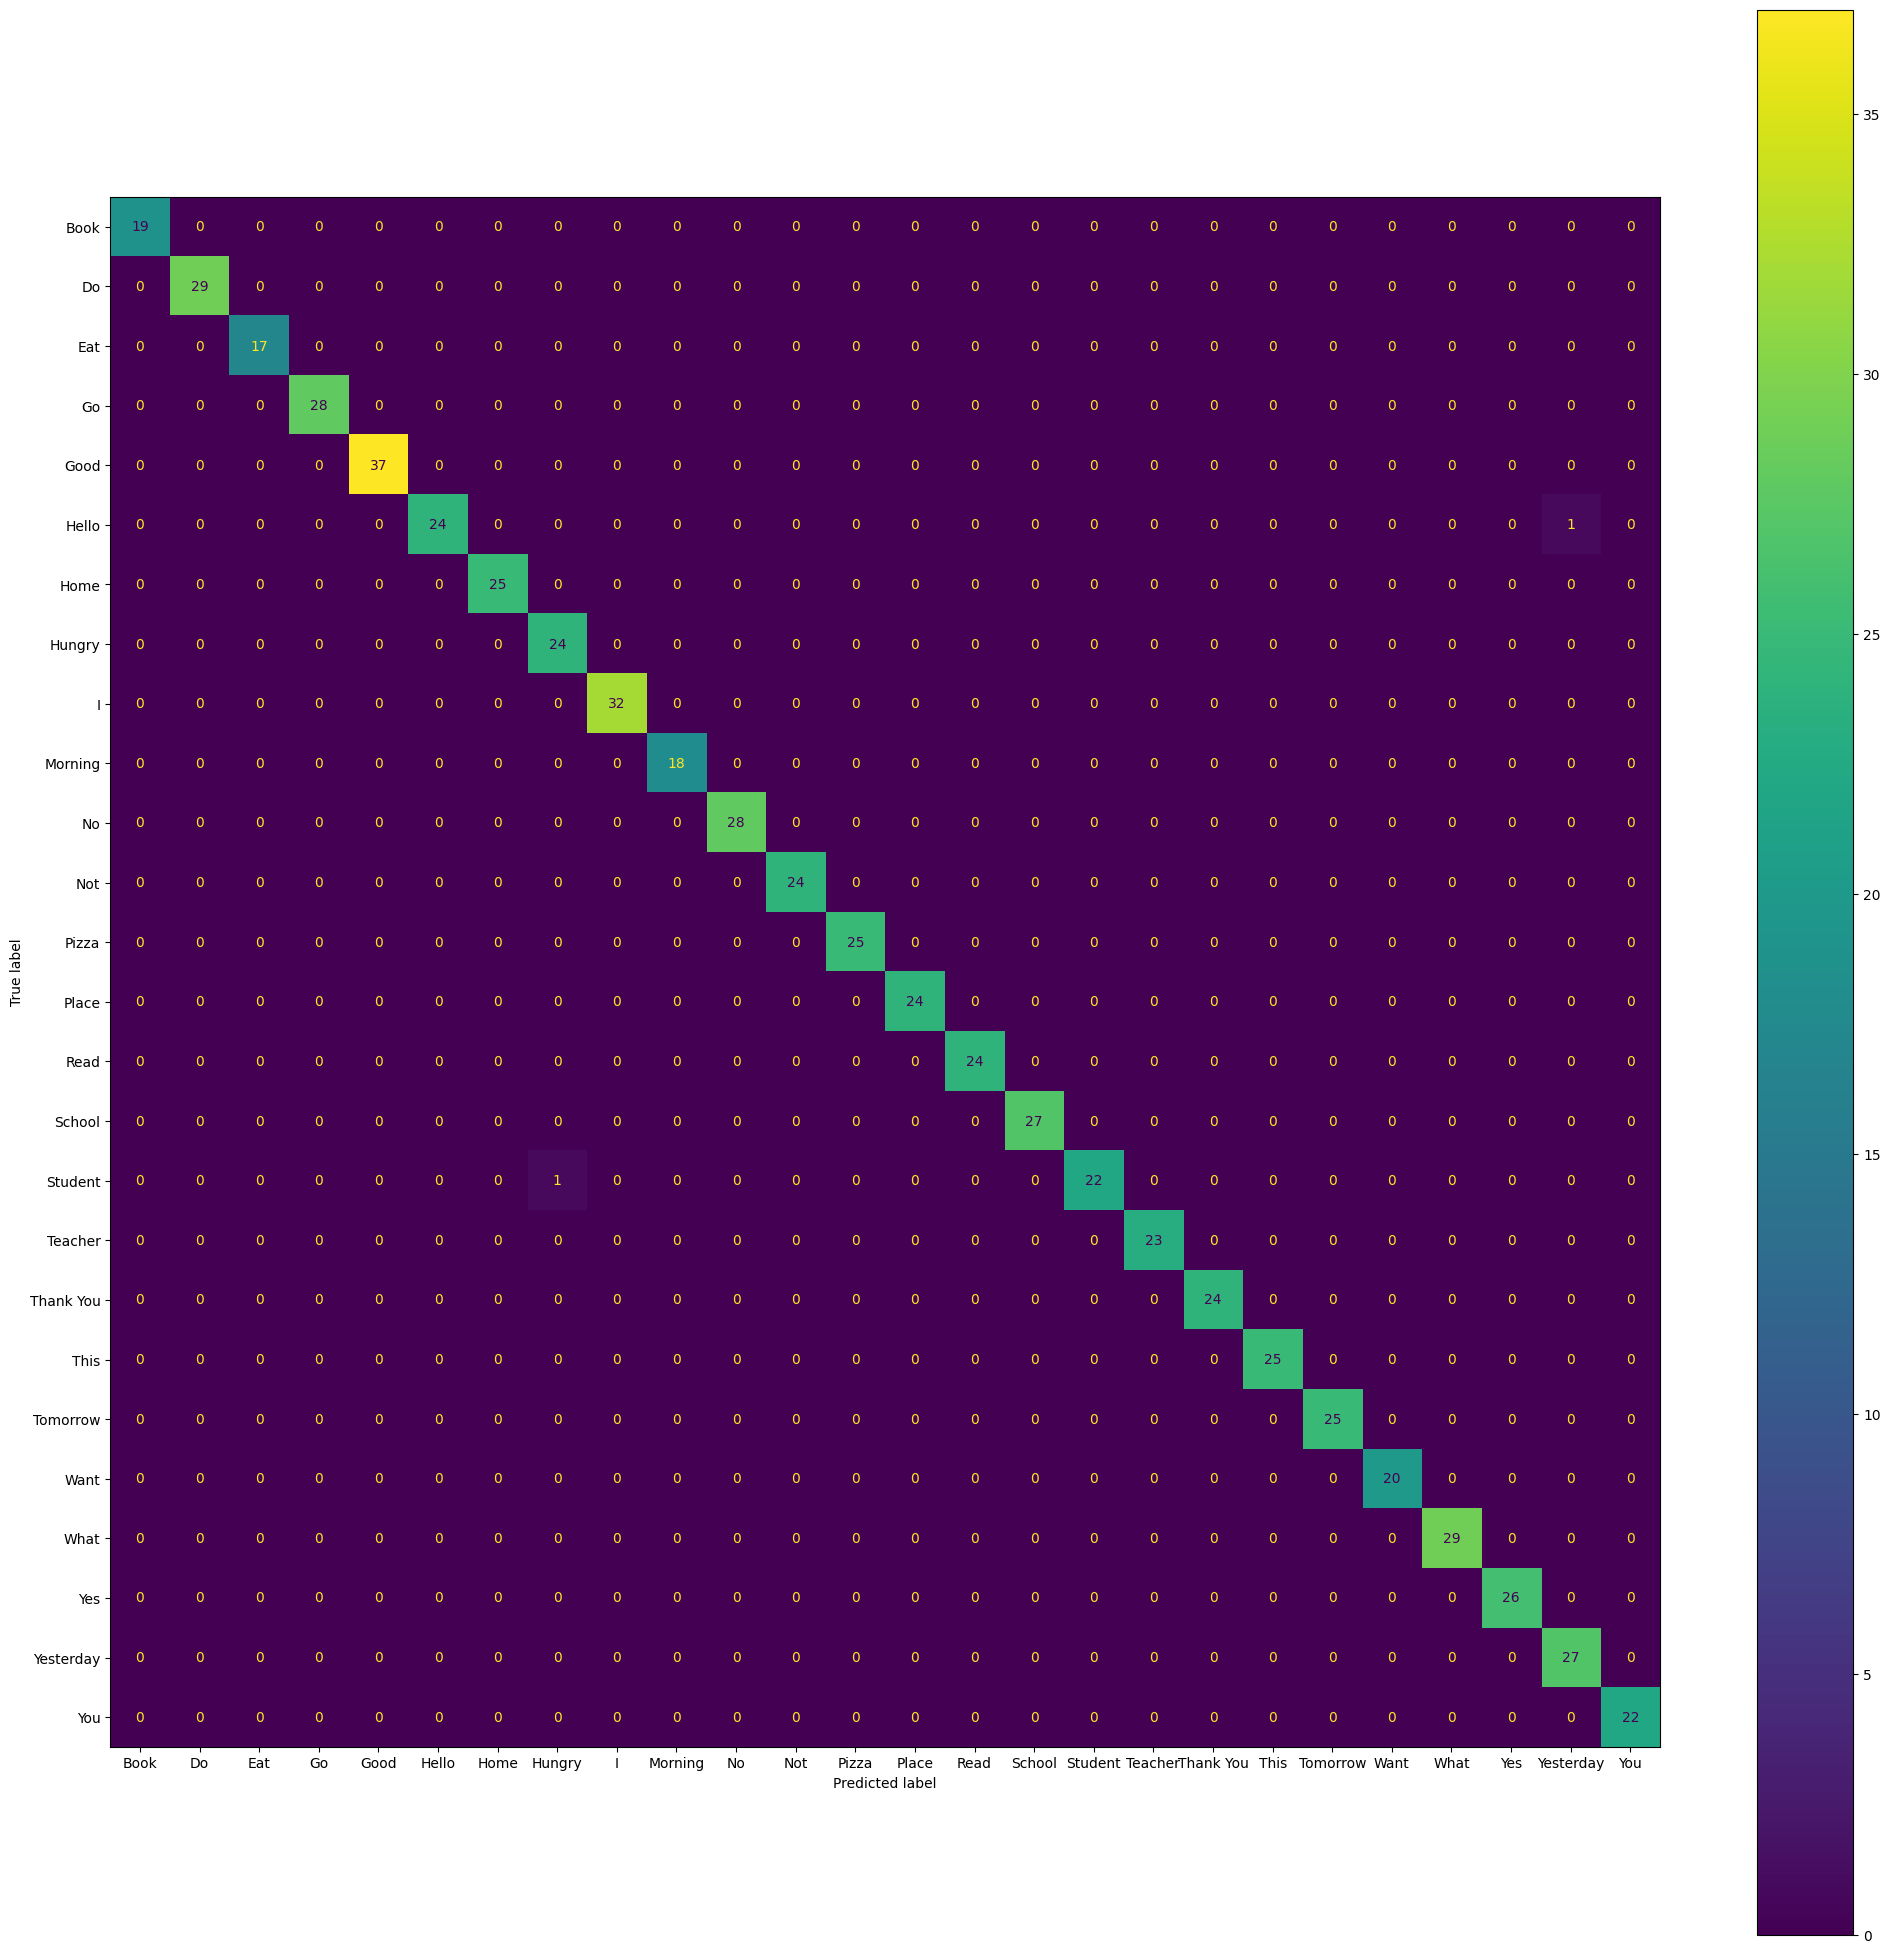

In [31]:
from sklearn import metrics
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion_matrix = metrics.confusion_matrix(actual, predicted)

# Automatically determine the unique labels from the data
unique_labels = sorted(set(actual) | set(predicted))

# Create a larger figure with specific dimensions
fig, ax = plt.subplots(figsize=(25, 25))  # Adjust the width and height as needed

# Display the confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=unique_labels)
cm_display.plot(ax=ax)  # Pass the ax object to plot on the adjusted figure size

plt.show()


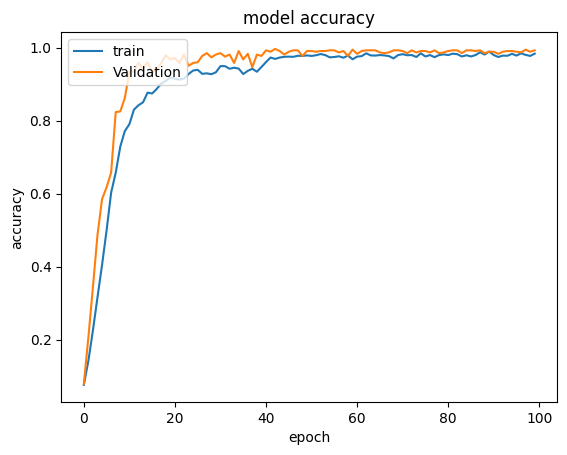

In [32]:
import matplotlib.pyplot as plt
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

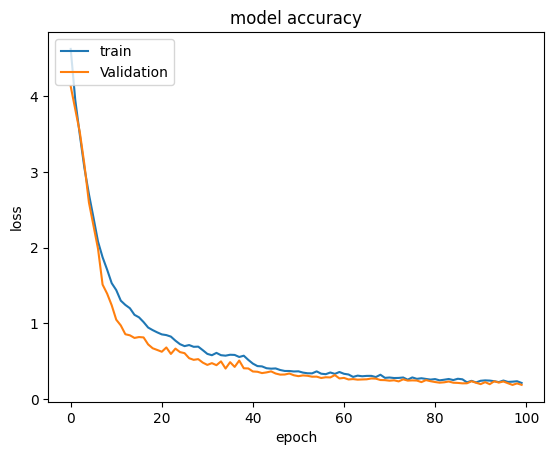

In [33]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [34]:
model2.save("model_new_final.h5")